# Run from Command Line:

```
jupyter nbconvert --execute --clear-output analysis_vuln/analysis.ipynb
```

In [6]:
library(tidyverse)
library(ggplot2)
library(lsr)
#library(kimisc)

In [7]:
setwd("/mnt/data/donald/pacsolve/slurm/analysis_vuln")

In [8]:
data_dir <- "../permanently_saved_results/federico-vuln-exp"
vuln <- read_csv(str_c(data_dir, "/aug_27_gather.csv"),
        col_types ="ccfddfc")
results_tex <- str_c(data_dir, "/results.tex")
plots_dir <- str_c(data_dir, "/plots")
write("% These are results from the R Notebook.", results_tex, append=FALSE)
dir.create(plots_dir, showWarnings = FALSE)
vuln <- vuln %>% select(-NDeps,-Status,-Time)

In [9]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  path <- str_c(plots_dir, "/", filename)
  ggsave(path, width=4, height=3, units=c("in"))
  # embed_font(path)
}

In [10]:
# What does it mean when status is "missing" - and should we only include those that have no missing?
# There are 225/1000 project-versions that have non-NA results: what is missing there?
vulnByProject <- vuln %>%
    # replace_na(list(CVE=-1)) %>%
    pivot_wider(names_from=solver, values_from=CVE, names_prefix="CVE.") #%>%
    # group_by(name,commit) %>%
    # summarise(across(starts_with("CVE."), ~sum(.x,na.rm=TRUE))) %>% ungroup()
head(vulnByProject)
nrow(vulnByProject)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
generator-react,09b724e,12.80,12.80,0.0,NA,NA
JsSIP,9cdeaa0,17.45,17.45,0.0,0,17.45
umi-plugin-datahub,0a4a4f9,33.10,33.10,202.5,NA,NA
postcss-assets-webpack-plugin,90b69bb,0.00,0.00,0.0,0,0.00
accord,262e693,0.00,0.00,0.0,0,0.00
asl-validator,88949ae,0.00,0.00,0.0,0,0.00


[1] 715

## How many times did MaxNPM come to a different CVE score than NPM audit fix?

In [11]:
# breaks <- c(0, 1, 10, 25, 50, 100, 1000)
# bucketedVuln <- vulnByProject %>%
#     filter(`CVE.audit fix` >= 0 & `CVE.audit fix force`>=0 & `CVE.maxnpm_cve_oldness`>=0) %>%
#     mutate(across(starts_with('CVE'), ~cut_format(.x, breaks=breaks))) %>% # Bucket all CVE columns
#     mutate_if(is.factor, as.character) %>%  # Default is these are factors, make them char so easier to handle
#     mutate(across(starts_with('CVE'), ~replace(.,is.na(.), '0'))) %>% # If it was NA, it was because it was outside of the range, aka == 0
#     group_by(`CVE.audit fix`,`CVE.maxnpm_cve_oldness`) %>% summarise(count=n()) %>%
#     # Sum the count for CVE audit fix and add a row for that called 'total'
#     bind_rows(group_by(.,`CVE.audit fix`) %>%
#         summarise(count=sum(count)) %>%
#         mutate(`CVE.maxnpm_cve_oldness`='Total')) %>%
#     bind_rows(group_by(.,`CVE.maxnpm_cve_oldness`) %>%
#         summarise(count=sum(count)) %>%
#         mutate(`CVE.audit fix`='Total'))

# # Create a matrix where the columns are for audit fix, rows are for MaxNPM
# bucketedVuln %>%
#     pivot_wider(names_from=`CVE.audit fix`, values_from=count) %>%
#     relocate(`0`, .before=`(   1,   10]`) %>%
#     mutate_if(is.numeric,~replace(.,is.na(.), 0)) %>%
#     arrange(CVE.maxnpm_cve_oldness) #%>%
#         # kable("html", booktabs=TRUE, linesep="", digits=0, escape=FALSE, format.args = list(big.mark = ",",
#         #   scientific = FALSE)) %>% as.character() %>% display_html()

In [12]:
vulnByProject %>% filter(name == 'spreadable')

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
spreadable,0803fae,28.5,28.5,13.1,94.8,110.2


## When MaxNPM outperformed NPM Audit, how much better was it?

Negative numbers are *better* because they are a decrease in badness.

In [13]:
change_cat <- function(x) {
    ifelse(is.na(x), NA, ifelse(x == 0, "same", ifelse(x > 0, "better", "worse")))
}

In [14]:
CVEDiff <- vulnByProject %>%
    mutate(CVEDiff=`CVE.audit fix` - `CVE.maxnpm_cve_oldness`, CVEPIPDiff=`CVE.audit fix` - `CVE.maxnpm_cve_oldness_pip_else_npm`) %>%
    mutate(CVEDiff=round(CVEDiff, 6)) %>%
    mutate(CVEPIPDiff=round(CVEPIPDiff, 6)) %>%
    mutate(CVEChangeCat=change_cat(CVEDiff)) %>%
    mutate(CVEPIPChangeCat=change_cat(CVEPIPDiff))

In [15]:
head(CVEDiff)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff,CVEPIPDiff,CVEChangeCat,CVEPIPChangeCat
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
generator-react,09b724e,12.80,12.80,0.0,NA,NA,NA,NA,NA,NA
JsSIP,9cdeaa0,17.45,17.45,0.0,0,17.45,17.45,0,better,same
umi-plugin-datahub,0a4a4f9,33.10,33.10,202.5,NA,NA,NA,NA,NA,NA
postcss-assets-webpack-plugin,90b69bb,0.00,0.00,0.0,0,0.00,0.00,0,same,same
accord,262e693,0.00,0.00,0.0,0,0.00,0.00,0,same,same
asl-validator,88949ae,0.00,0.00,0.0,0,0.00,0.00,0,same,same


Warning message:
“Removed 243 rows containing non-finite values (stat_ecdf).”
Warning message:
“Removed 243 rows containing non-finite values (stat_ecdf).”


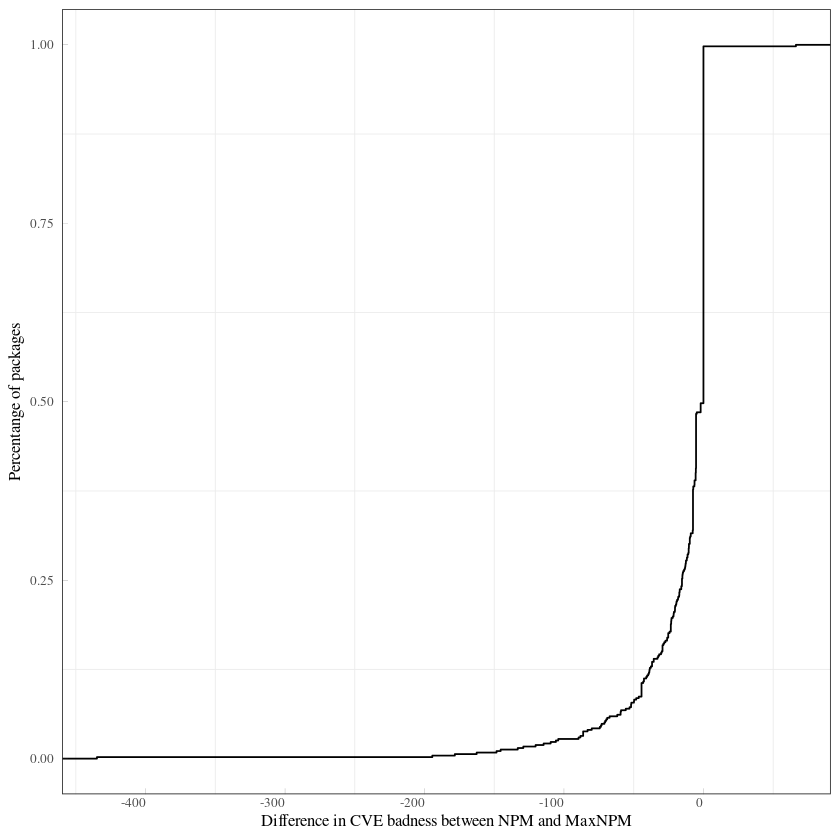

In [16]:
CVEDiff %>% 
  ggplot(aes(`CVE.maxnpm_cve_oldness` - `CVE.audit fix`  )) +
  stat_ecdf() +
  ylab("Percentange of packages") +
  xlab("Difference in CVE badness between NPM and MaxNPM") +
  mytheme()
mysave("cve-diff-ecdf.pdf")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



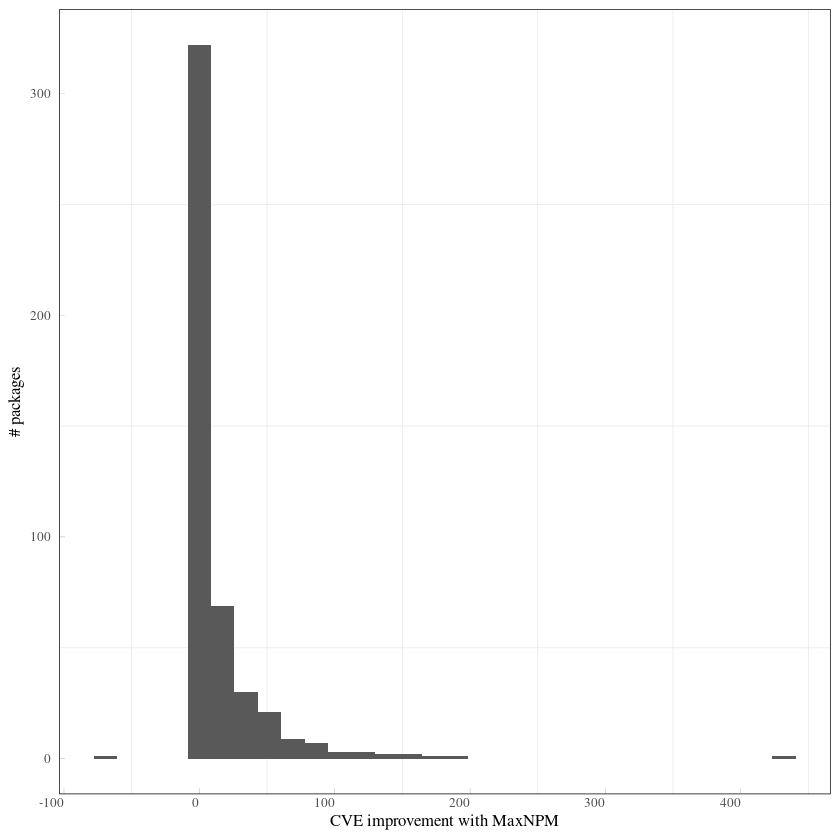

In [17]:
# CombinedData <- CVEDiff %>% 
#     filter(!is.na(CVEDiff))# %>%
#     # filter(CVEDiff >= -50 & CVEDiff <= 300)

# same_rows <- CombinedData %>% filter(CVEChangeCat != 'better')
# better_rows <- CombinedData %>% filter(CVEChangeCat == 'better')
# # worse_rows <- CombinedData %>% filter(CVEChangeCat == 'worse')

# colors <- c("Same or Worse" = "gray", "Better" = "#00BA38")
# ggplot(CombinedData, aes(x= CVEDiff)) + mytheme() + 
#     geom_histogram(data = same_rows, aes(fill = "Same or Worse"), alpha = 1, bins=50) + 
#     geom_histogram(data = better_rows, aes(fill = "Better"), alpha=1, bins=50) + 
#     scale_fill_manual(values=colors) + xlab('CVE improvement with MaxNPM') + 
#     ylab('Count') #+
#     #coord_trans(x="log2")
#     # scale_y_continuous(trans='log10')
#     #scale_x_continuous(trans='log10')

CVEDiff %>% filter(!is.na(CVEDiff)) %>%
    ggplot(aes(x=CVEDiff)) +
    geom_histogram() +
    xlab('CVE improvement with MaxNPM') + 
    ylab('# packages') +
    mytheme()

mysave('cve-diff-hist.pdf')

In [18]:
CVEDiff %>% filter(`CVE.maxnpm_cve_oldness` == `CVE.vanilla`)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff,CVEPIPDiff,CVEChangeCat,CVEPIPChangeCat
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
postcss-assets-webpack-plugin,90b69bb,0.00,0.00,0.00,0.00,0.00,0,0,same,same
accord,262e693,0.00,0.00,0.00,0.00,0.00,0,0,same,same
asl-validator,88949ae,0.00,0.00,0.00,0.00,0.00,0,0,same,same
lz,126e910,0.00,0.00,0.00,0.00,0.00,0,0,same,same
microservice-call,33daf19,0.00,0.00,0.00,0.00,0.00,0,0,same,same
node-mailchimp,cbbab51,0.00,0.00,0.00,0.00,0.00,0,0,same,same
cabin,9a3b169,0.00,0.00,0.00,0.00,0.00,0,0,same,same
license-checker,315de0b,0.00,0.00,0.00,0.00,0.00,0,0,same,same
loopback-next,02ba54b,0.00,0.00,0.00,0.00,0.00,0,0,same,same


## Statistical Tests

In [35]:
# Mean percent improvement
perc_improvements <- (CVEDiff$`CVE.audit fix` - CVEDiff$CVE.maxnpm_cve_oldness) / CVEDiff$`CVE.audit fix`
perc_improvements[is.na(perc_improvements)] <- 0
mean(perc_improvements) * 100

[1] 30.50952

In [36]:
shapiro.test(CVEDiff$`CVE.audit fix`)
shapiro.test(CVEDiff$CVE.maxnpm_cve_oldness)


	Shapiro-Wilk normality test

data:  CVEDiff$`CVE.audit fix`
W = 0.40206, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  CVEDiff$CVE.maxnpm_cve_oldness
W = 0.26915, p-value < 2.2e-16


They aren't normally distributed, so we do Wilcoxon signed rank test

In [37]:
wilcox.test(CVEDiff$`CVE.audit fix`, CVEDiff$CVE.maxnpm_cve_oldness, paired = TRUE, alternative = "greater")


	Wilcoxon signed rank test with continuity correction

data:  CVEDiff$`CVE.audit fix` and CVEDiff$CVE.maxnpm_cve_oldness
V = 28230, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


So, `CVEDiff$CVE.maxnpm_cve_oldness` is statistically smaller!

In [38]:
cohensD(CVEDiff$`CVE.audit fix`, CVEDiff$CVE.maxnpm_cve_oldness)

[1] 0.4584651

## Main Results

In [30]:
total_count <- nrow(CVEDiff)
all_ok_count <- nrow(CVEDiff %>% filter(!is.na(CVEDiff)))
maxnpm_better_count <- nrow(CVEDiff %>% filter(CVEDiff > 0))
maxnpm_same_count <- nrow(CVEDiff %>% filter(CVEDiff == 0))
maxnpm_worse_count <- nrow(CVEDiff %>% filter(CVEDiff < 0))
fixed_all_vulns_count <- nrow(CVEDiff %>% filter(`CVE.audit fix` > 0) %>% filter(`CVE.maxnpm_cve_oldness` == 0))
cve_diff_mean <- mean(CVEDiff$CVEDiff, na.rm=T)
all_ok_perc <- all_ok_count / total_count
maxnpm_better_total_perc <- maxnpm_better_count / total_count
maxnpm_better_ok_perc <- maxnpm_better_count / all_ok_count

write(
  str_c("\\newcommand{\\dataCveExpTotalCount}{", 
        total_count,
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpSuccessCount}{", 
        all_ok_count,
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmBetterCount}{", 
        maxnpm_better_count,
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmSameCount}{", 
        maxnpm_same_count,
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmWorseCount}{", 
        maxnpm_worse_count,
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMeanCveDiff}{", 
        round(cve_diff_mean, 2),
        "}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpSuccessPerc}{", 
        round(100 * all_ok_perc),
        "\\%}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmBetterTotalPerc}{", 
        round(100 * maxnpm_better_total_perc),
        "\\%}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmBetterSuccessPerc}{", 
        round(100 * maxnpm_better_ok_perc),
        "\\%}\n"),
  results_tex, append=TRUE)
write(
  str_c("\\newcommand{\\dataCveExpMaxNpmFixedCompletelyCount}{", 
        fixed_all_vulns_count,
        "}\n"),
  results_tex, append=TRUE)


# These are the ones where MaxNPM did worse somehow?

In [20]:
CVEDiff %>% filter(CVEDiff < 0)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff,CVEPIPDiff,CVEChangeCat,CVEPIPChangeCat
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
spreadable,0803fae,28.5,28.5,13.1,94.8,110.2,-66.3,-81.7,worse,worse


# These are the ones where MaxNPM did the best

In [21]:
CVEDiff %>% filter(CVEDiff > 0) %>% arrange(desc(CVEDiff))

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff,CVEPIPDiff,CVEChangeCat,CVEPIPChangeCat
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
node-db-migrate,0354de8,434.85,434.85,0.00,0.00,NA,434.85,NA,better,NA
dgeni-packages,3c75243,201.90,201.90,7.50,7.50,185.70,194.40,16.20,better,better
grant,762badb,259.60,259.60,94.30,81.35,204.25,178.25,55.35,better,better
lockit-sql-adapter,b3171b3,162.60,162.60,0.00,0.00,NA,162.60,NA,better,NA
storyboard,3c0fa91,148.35,148.35,0.00,0.00,132.35,148.35,16.00,better,better
gulp-typedoc,039d47b,145.40,145.40,0.00,0.00,140.10,145.40,5.30,better,better
apidoc,0b5d254,133.15,133.15,0.00,0.00,133.15,133.15,0.00,better,same
release-it,0ae3e3c,132.85,132.85,48.10,3.70,132.85,129.15,0.00,better,same
ui,1de6835,127.85,127.85,7.50,7.50,NA,120.35,NA,better,NA
